<b>Machine Learning Model for identify glass type</b> <br>
We build a simple model using the glass.csv data set for identify glass type.

Author: Potiatynok V. Date: 05/11/2021

# 1. Read dataset and display columns

In [103]:
import pandas as pd # linear algebra
import numpy as np # read and wrangle dataframe
np.random.seed(25)

import eli5
import sys
from collections import Counter

from sklearn.model_selection import StratifiedKFold, learning_curve, train_test_split, cross_val_score #cross-validation
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc  #metrics
#tuning
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

#load models
import xgboost as xgb
import catboost as ctb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

#profile report
from pandas_profiling import ProfileReport

# visualization
import matplotlib.pyplot as plt 
import seaborn as sns
from scikitplot.estimators import plot_learning_curve
sns.set(rc={'figure.figsize':(20,10)})

%matplotlib inline

In [97]:
df = pd.read_csv('glass.csv')
feat = df.columns[:-1].tolist()
df.head(10)

RI     Na    Mg    Al     Si     K    Ca   Ba    Fe  Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.00     1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.00     1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.00     1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.00     1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.00     1
5  1.51596  12.79  3.61  1.62  72.97  0.64  8.07  0.0  0.26     1
6  1.51743  13.30  3.60  1.14  73.09  0.58  8.17  0.0  0.00     1
7  1.51756  13.15  3.61  1.05  73.24  0.57  8.24  0.0  0.00     1
8  1.51918  14.04  3.58  1.37  72.08  0.56  8.30  0.0  0.00     1
9  1.51755  13.00  3.60  1.36  72.99  0.57  8.40  0.0  0.11     1

Creating a report for DataFrame, to have a quick view on it.

In [3]:
profile = ProfileReport(df)
profile.to_file(output_file="my_report.html") #profile report saved in html format

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [116]:
df.Type.value_counts()

2    70
1    70
7    25
3    17
5    10
6     8
Name: Type, dtype: int64

The dataset has 214 records. Our features will be all columns except "Type" as it is our target.

# 2. Check missing data

In [23]:
df.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

No missing data

# 3. Calculate basic statistics of the data

In [24]:
df.describe()

RI          Na          Mg          Al          Si           K  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516523   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

               Ca          Ba          Fe        Type  
count  214.000000  214.000000  214.000000  214.000000  
mean     8.956963    0.175047    0.057009    2.780374  
std      1.423153    0.497219    0.097439    2.103739  
min      5.430000    0.000000    0.000000    1.000000  
25%      8.240000    0.000000    0.000000    1.000000  
50%      8.600000    0.000000    0.000000    2.000000  
75%      9.172500    0.000000    0.100000    3.000000  
max     16.190000    3.150000    0.510000    7.000000

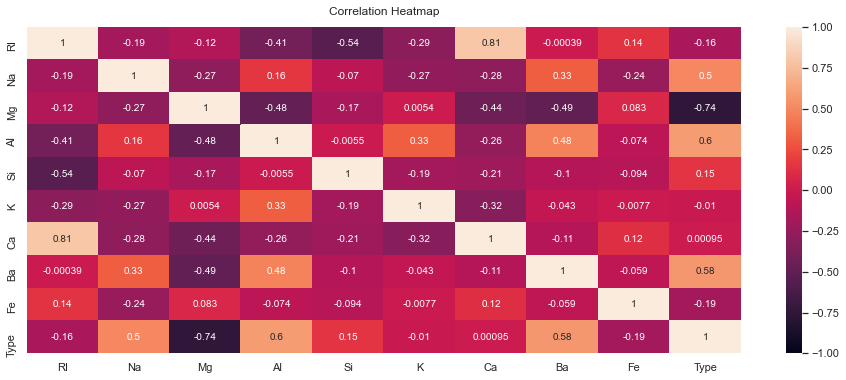

In [20]:
plt.figure(figsize=(16,6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# 4. Visualize data

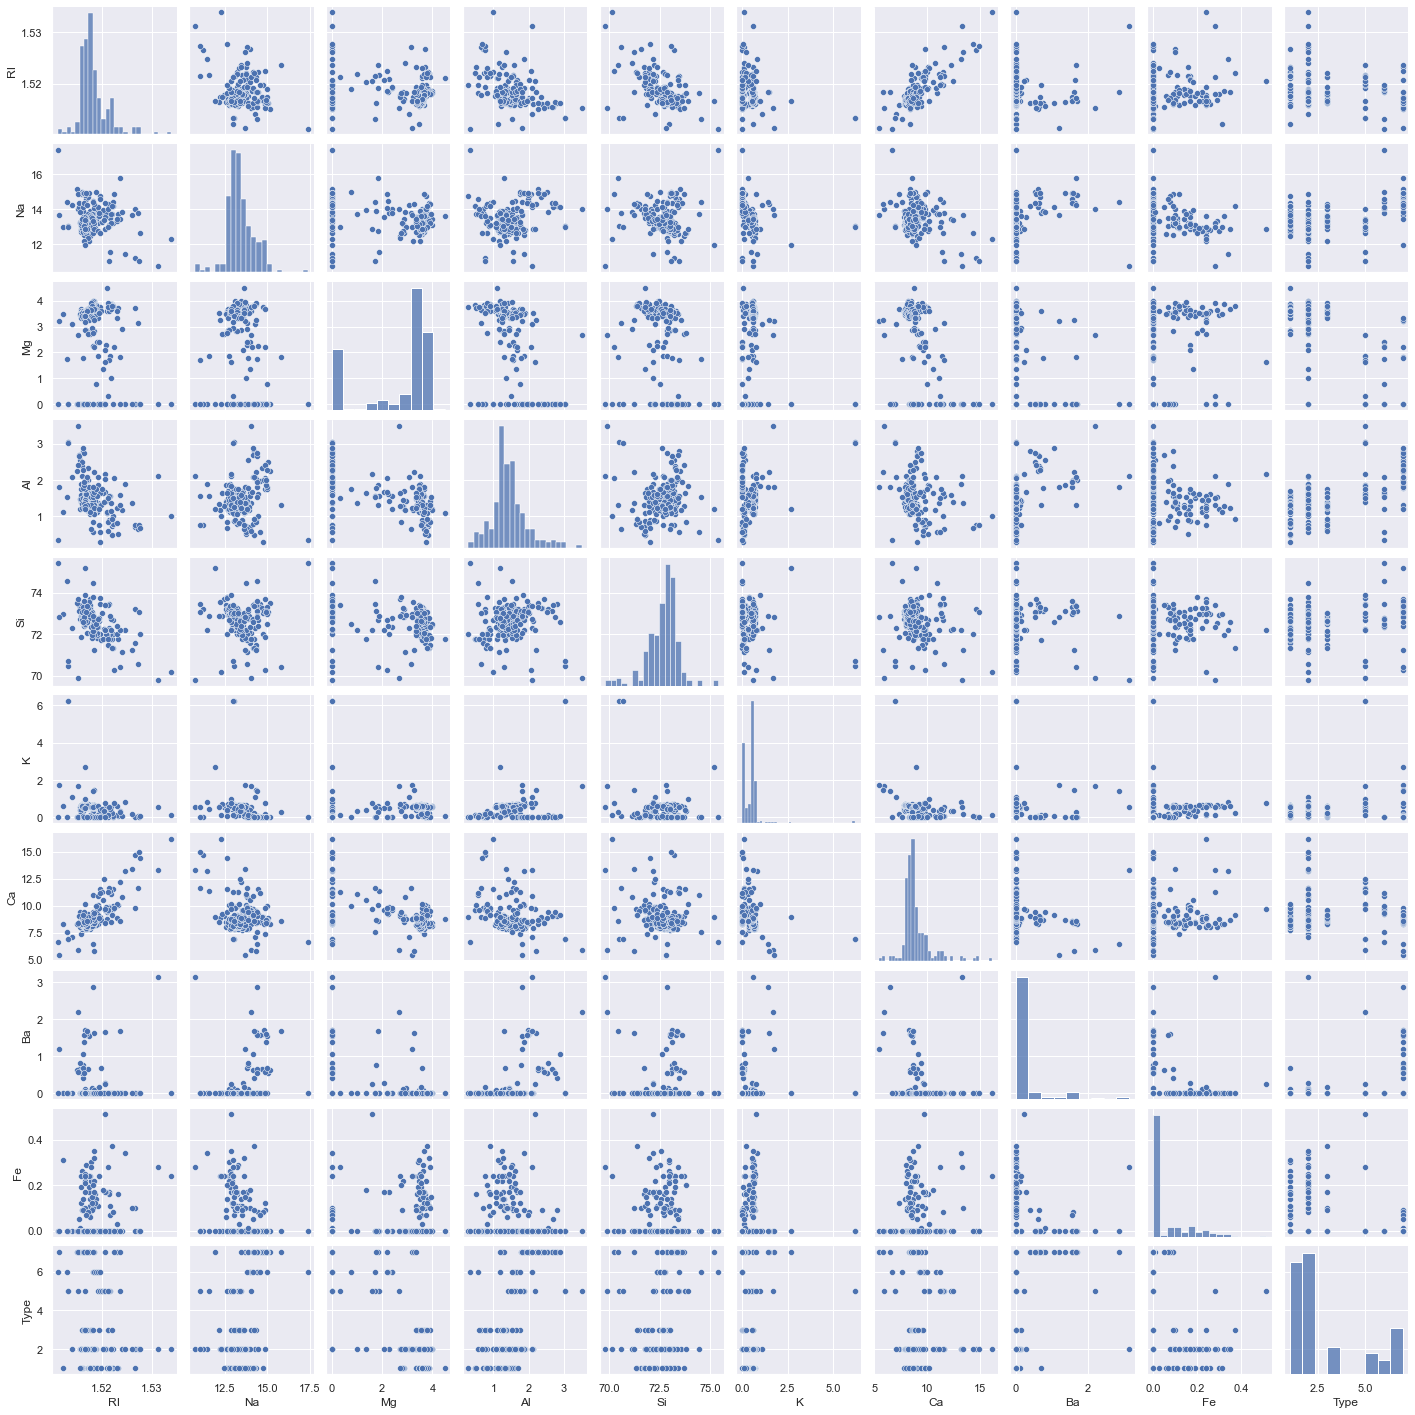

In [8]:
sns.pairplot(df, height=2.0);

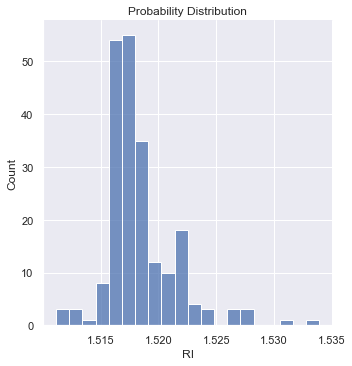

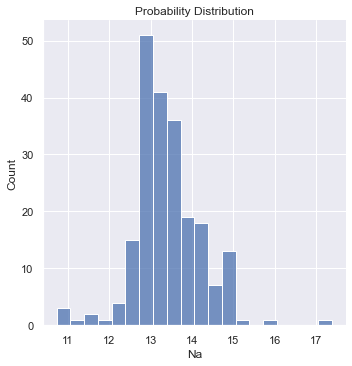

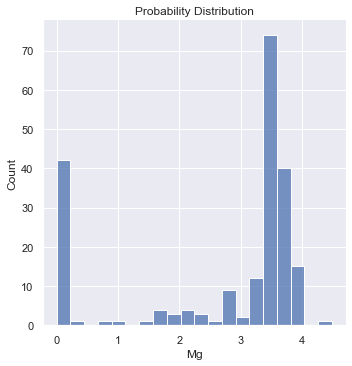

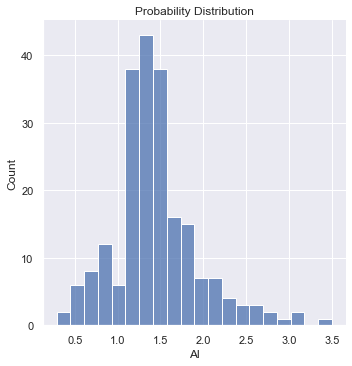

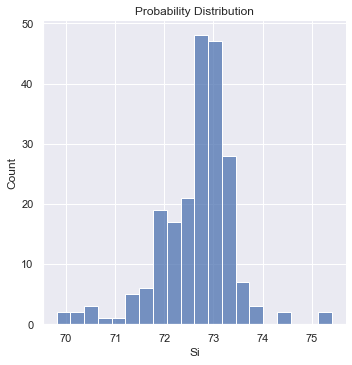

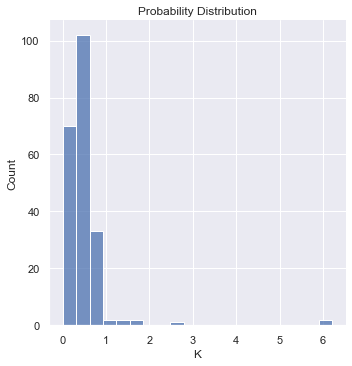

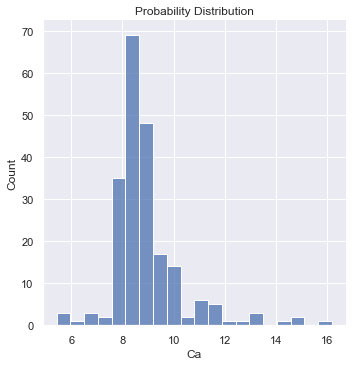

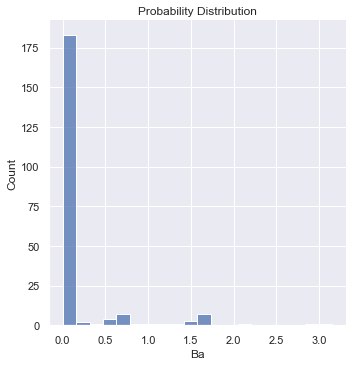

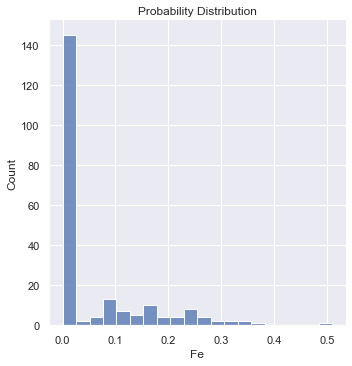

In [9]:
for feat in df.columns[:-1].values:
    sns.displot(df[feat],bins=20)
    plt.title('Probability Distribution')
    plt.show()

From above plots we see that we need to normalize a data, before runing a model. Unfortunately we don't have normall distribution, so to continue we remove outliers.

# 5. Removing outliers

To identify the indices of the observations containing outliers we use Turkey's method.

In [98]:
def removing_outliers(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for x in df.columns:
        # 1st and 2nd quartile
        q75, q25 = np.percentile(df.loc[:,x],[75, 25])
        
        # Interquartile range (IQR)
        iqr = q75 - q25
        
        # outlier step
        outlier_step = 1.5 * iqr
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[x] < q25 - outlier_step) | (df[x] > q75 + outlier_step)].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers
        

In [99]:
out = removing_outliers(df[feat])
df = df.drop(out).reset_index(drop = True)

In [100]:
print(df.shape)

(200, 10)


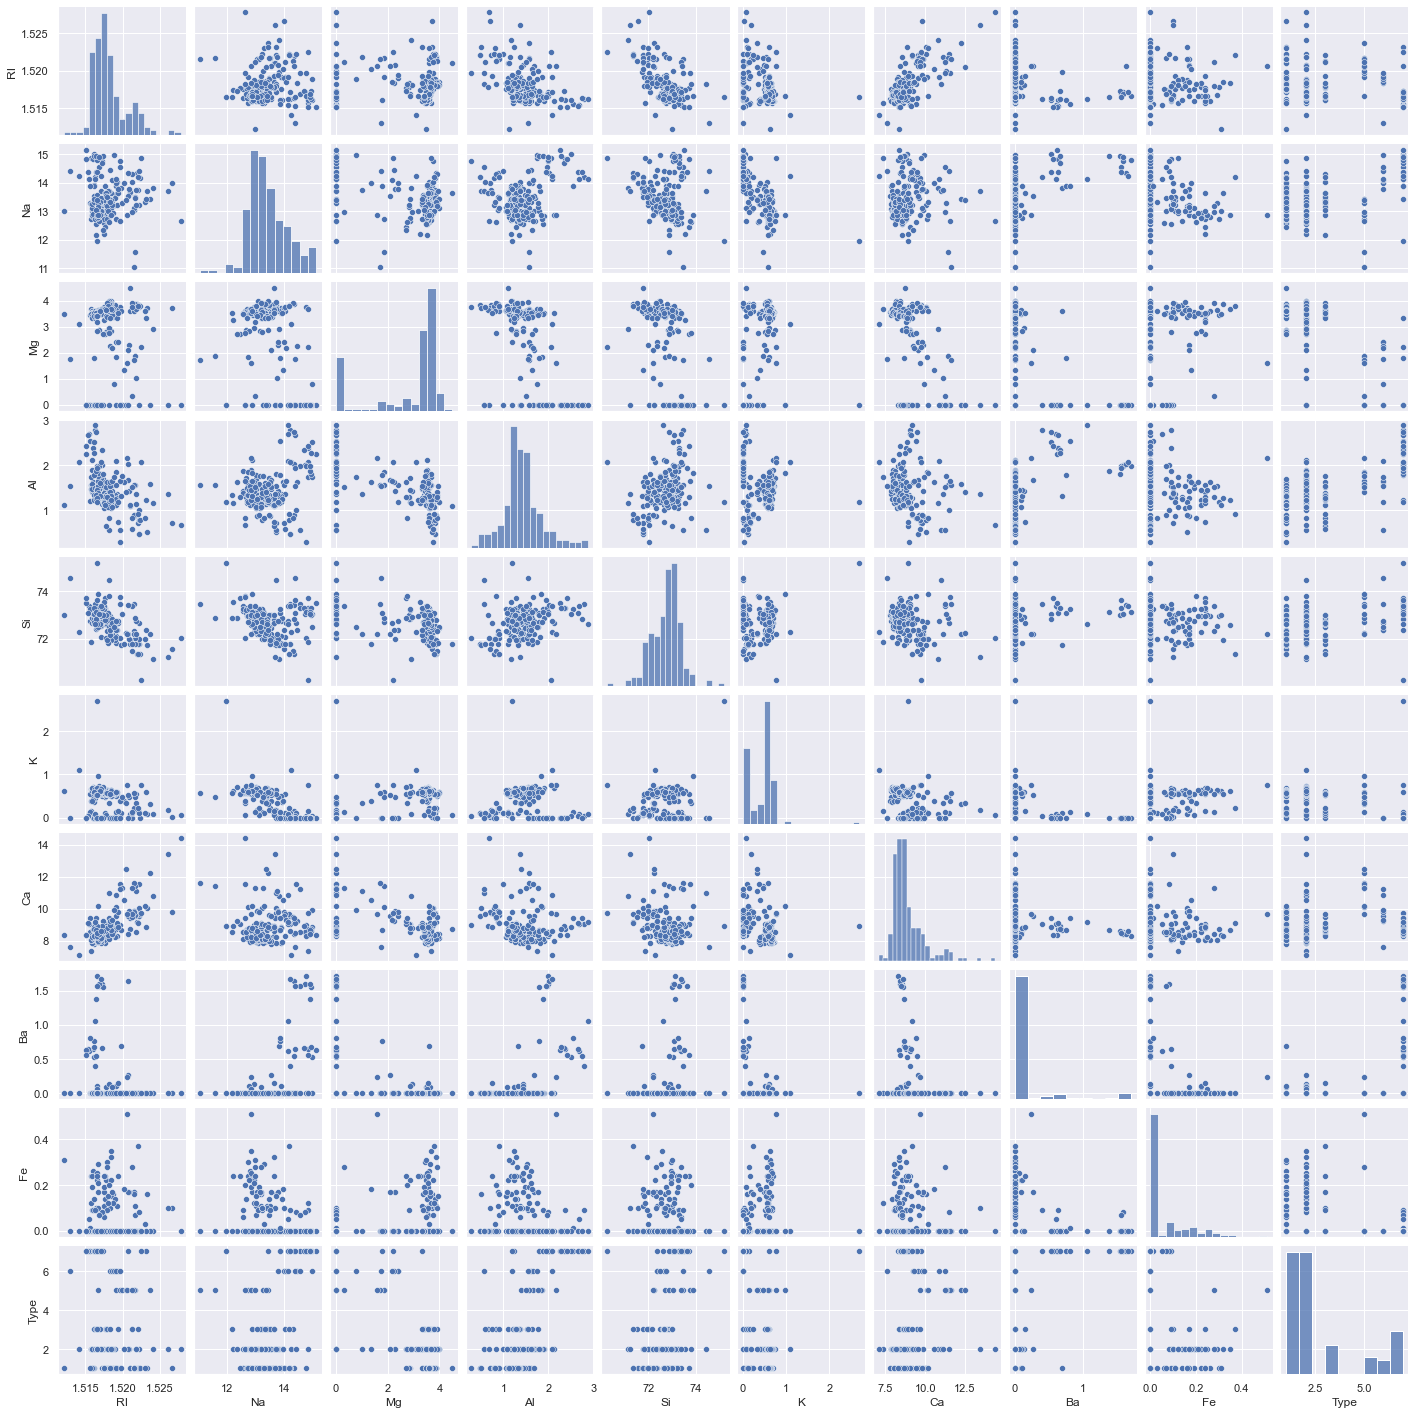

In [24]:
sns.pairplot(df, height=2.0);

 # 6. Data partitioning into training and testing sets

In [118]:
feat = df.columns
black_list = ['Type']
feat = [x for x in feat if x not in black_list]
X = df[feat]
y = df["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 20, shuffle = True)

# 7. Building a model

In [107]:
def get_models():
    return [
#         ('dt', DecisionTreeClassifier(min_samples_leaf=10,max_depth=30, random_state=25)),
          ("ctb", ctb.CatBoostClassifier(iterations=50, max_depth=5, verbose=False)),
#         ("xgb", xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=25)),
#         ("rf", RandomForestClassifier(n_estimators=50, min_samples_leaf=10,max_depth=30,random_state=25)),
#         ("ext-tr", ExtraTreesClassifier(n_estimators=50, min_samples_leaf=10,max_depth=30,random_state=25))       
    ]


def run_cv(model, X, y, folds, cv_type=StratifiedKFold):
    cv = cv_type(n_splits=folds, random_state=0, shuffle = True)
    scores = cross_val_score(model, X, y, cv=cv, scoring = 'f1_micro')
    return np.mean(scores), np.std(scores)
    
    
def run(X, y, folds = 4):
    for model_name, model in get_models():
        score_mean, score_std = run_cv(model, X, y, folds=folds)
        print("[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std))
        sys.stdout.flush()
        

In [108]:
run(X, y)

[ctb]: 0.75 +/-0.033166247903554075


[dt]: 0.63 +/-0.06557438524302002 <br>
[ctb]: 0.7649999999999999 +/-0.049749371855331 <br>
[xgb]: 0.7100000000000001 +/-0.05196152422706631 <br>
[rf]: 0.655 +/-0.021794494717703387 <br>
[ext-tr]: 0.625 +/-0.038405728739343024

So the best model was CatBoostClassifier, let's improve our score by tuning the parameters.

# 8. Tuning parameters

In [109]:
def objective(space):
    
    ctb_params = {
        'iterations': int(space['iterations']),
        'depth': int(space['depth']),
        'learning_rate': float(space['learning_rate']),
        'random_state': 25,
        'verbose': False,
        'ctr_leaf_count_limit': int(space['ctr_leaf_count_limit']),
    }
    
    model = ctb.CatBoostClassifier(**ctb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = f1_score(y_test, y_pred, average='micro')
    
    loss = 1 - score
    
    return{'loss':loss, 'status': STATUS_OK }
                            
space ={
    'depth': hp.quniform ('x_depth', 5, 16, 1),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'iterations': hp.quniform ('x_iterations', 1, 1000, 25),
    'ctr_leaf_count_limit': hp.quniform ('x_ctr_leaf_count_limit', 20, 200, 20),
}

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=5),
            max_evals=20,
            trials=trials)

print("The best params: ", best_params)

100%|██████████████████████████████████████████████| 20/20 [51:03<00:00, 153.17s/trial, best loss: 0.30000000000000004]
The best params:  {'x_ctr_leaf_count_limit': 20.0, 'x_depth': 10.0, 'x_iterations': 900.0, 'x_learning_rate': 0.05295537280025529}


In [110]:
def get_models():
    return [
#        ('dt', DecisionTreeClassifier(min_samples_leaf=10,max_depth=30, random_state=25)),
         ("ctb", ctb.CatBoostClassifier(iterations=900, depth=10, learning_rate=0.05295537280025529, ctr_leaf_count_limit=20, verbose=False,random_state=25)),
#        ("xgb", xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=25)),
#        ("rf", RandomForestClassifier(n_estimators=50, min_samples_leaf=10,max_depth=30,random_state=25)),
#        ("ext-tr", ExtraTreesClassifier(n_estimators=50, min_samples_leaf=10,max_depth=30,random_state=25))       
    ]
run(X, y)

[ctb]: 0.77 +/-0.022360679774997956


Above result we received after removing "K", "Ba", "Fe" due to high standard deviations compared to their mean.

f1_score 0.8000000000000002


<AxesSubplot:>

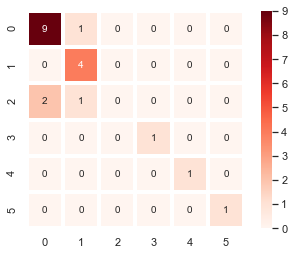

In [153]:
model = ctb.CatBoostClassifier(iterations=900, depth=10, learning_rate=0.05295537280025529, ctr_leaf_count_limit=20, verbose=False,random_state=25)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
score = f1_score(y_test, y_pred, average='micro')
print(f'f1_score {score}')
cm = confusion_matrix(y_test,y_pred)
plt.ylabel('actual label')
plt.xlabel('predicted label')
sns.heatmap(cm, annot=True,fmt=".0f",linewidths=3,square=True, cmap='Reds', color="#cd1076")